In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from xgboost import XGBClassifier
from sklearn import svm
import time
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score
import shap
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE

'''
The first cell in this script generates the final feature sets,
you just need to choose either kmeans or gmm in the cluster_definition function call below.
The output files will be called train_df_kmeans or test_df_kmeans, or gmm if you choose that.

The latter cells run the ML models (RF, SVM, XGB) along with shap importance
'''

def cluster_definition(cluster_method,k): #Choose method, and K for Kmeans
    if cluster_method == 'kmeans':
        cluster_train = f'Train {k}Kmeans.csv'
        cluster_test = f'Test {k}Kmeans.csv'
        cluster_mem = 'cluster_kmeans'
        cluster_method='kmeans'
    elif cluster_method == 'gmm':
        cluster_train = 'Train 2GMM.csv'
        cluster_test = 'Test 2GMM.csv'
        cluster_mem = 'cluster_ncomponents'
        cluster_method='gmm'
    return(cluster_train, cluster_test, cluster_mem, cluster_method, k)
cluster_train, cluster_test, cluster_mem, cluster_method, k = cluster_definition('gmm',k=6)

#Feature set generation
covariates = ['BMI.0.0', 'Age_recr.0.0', 'Smoking_status.0.0', 'Sex.0.0']
clusters_df_train = pd.read_csv(f"../Clustering_temp/{cluster_train}")
blood_counts = list(clusters_df_train.columns[:-1])
clusters_df_train=clusters_df_train[cluster_mem]
clusters_df_test = pd.read_csv(f"../Clustering_temp/{cluster_test}")
clusters_df_test=clusters_df_test[cluster_mem]
lifestyle=["Mood_swings.0.0","Alc_drinker_status.0.0","C_reactive_protein.0.0","Traff_int_major_rd.0.0","housing_score"]


#Train Data generation
train_data = pd.read_csv("../matching/matched_df.csv")
X_train=train_data[covariates+blood_counts+lifestyle]
y_train = train_data['cancer']
X_train=pd.merge(X_train,clusters_df_train,left_index=True, right_index=True)

#Test Data generation
test_data = pd.read_csv("../imp_test/test_imputed_df.csv")
X_test=test_data[covariates+blood_counts+lifestyle]
y_test = test_data['cancer']
X_test=pd.merge(X_test,clusters_df_test,left_index=True, right_index=True)

#Standardization
sclr=StandardScaler()
X_cols = X_train.columns
# Specify elements to remove
elements_categorical = ['Smoking_status.0.0', 'Sex.0.0','Mood_swings.0.0','Alc_drinker_status.0.0',cluster_mem]
# Create a new list that excludes the specified elements
continuous_cols = [x for x in covariates+blood_counts+lifestyle if x not in elements_categorical]
X_train[continuous_cols] = sclr.fit_transform(X_train[continuous_cols])
X_train = pd.DataFrame(X_train, columns = X_cols)
X_test[continuous_cols] = sclr.fit_transform(X_test[continuous_cols])
X_test = pd.DataFrame(X_test, columns = X_cols)
# One-hot encode the specified columns
X_train = pd.get_dummies(X_train, columns=elements_categorical)
X_test = pd.get_dummies(X_test, columns=elements_categorical)

#Ensuring all columns are present in both train and test sets
if cluster_method == 'kmeans':
    clusters = X_train.columns[-k:]
elif cluster_method == 'gmm':
    clusters = X_train.columns[-2:]
for cluster in clusters:
    if cluster not in X_test.columns:
        X_test[cluster]=0

X_test.rename(columns={'Sex.0.0_0.0': 'Sex.0.0_0','Sex.0.0_1.0':'Sex.0.0_1'}, inplace=True)

#Feature set generation
if cluster_method == 'gmm':
    X_train.to_csv(f'train_df_{cluster_method}.csv')
    X_test.to_csv(f'test_df_{cluster_method}.csv')
elif cluster_method == 'kmeans':
    X_train.to_csv(f'train_df_{k}{cluster_method}.csv')
    X_test.to_csv(f'test_df_{k}{cluster_method}.csv')


In [100]:
### GENERATING FEATURE SETS
covariates = ['BMI.0.0', 'Age_recr.0.0','Smoking_status.0.0_0', 'Smoking_status.0.0_1', 'Smoking_status.0.0_2',
       'Sex.0.0_0', 'Sex.0.0_1']
def feature_chooser(features, covariates=covariates, blood_counts=blood_counts, 
                    lifestyle=lifestyle, clusters=list(clusters), X_train=X_train, X_test=X_test):
    if features == 'covariates':
        columns = covariates
    elif features == 'blood counts':
        columns = covariates + blood_counts 
    elif features == 'clustered':
        columns = covariates + clusters
    elif features == 'complete':
        columns = list(set(X_train.columns) - set(blood_counts))
    X_train_subset = X_train[columns]
    X_test_subset = X_test[columns]
    return X_train_subset, X_test_subset
X_train_subset, X_test_subset = feature_chooser('complete')

#Resampling - use X_train_resampled and y_train_resampled if you want this
ros = SMOTE(random_state=42) #Set the number of cases you want specifically via argument 'sampling strategy'
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_subset, y_train)
class_counts = y_train_resampled.value_counts()
print(class_counts)

#BINARY VERSION - Combining Leukaemia and lymphoma into 1
y_train_binary = y_train.replace({'lymphoma':'cancer','leukemia':'cancer'})
y_test_binary = y_test.replace({'lymphoma':'cancer','leukemia':'cancer'})

if cluster_method=='kmeans':
    #High WBC cluster or not for 2 cluster 
    X_train_wbc = X_train_subset.copy()
    X_test_wbc = X_test_subset.copy()
    for i in range(1,6):
        X_train_wbc = X_train_wbc.drop(columns=f'cluster_kmeans_{i}')
        X_test_wbc = X_test_wbc.drop(columns=f'cluster_kmeans_{i}')


leukemia    10657
lymphoma    10657
healthy     10657
Name: cancer, dtype: int64


Index(['Mood_swings.0.0_1', 'Alc_drinker_status.0.0_0',
       'C_reactive_protein.0.0', 'Smoking_status.0.0_2', 'Mood_swings.0.0_0',
       'housing_score', 'Age_recr.0.0', 'Alc_drinker_status.0.0_1',
       'Sex.0.0_1', 'Sex.0.0_0', 'Smoking_status.0.0_1',
       'Smoking_status.0.0_0', 'cluster_ncomponents_1',
       'Traff_int_major_rd.0.0', 'Alc_drinker_status.0.0_2', 'BMI.0.0',
       'cluster_ncomponents_0'],
      dtype='object')
Index(['Mood_swings.0.0_1', 'Alc_drinker_status.0.0_0',
       'C_reactive_protein.0.0', 'Smoking_status.0.0_2', 'Mood_swings.0.0_0',
       'housing_score', 'Age_recr.0.0', 'Alc_drinker_status.0.0_1',
       'Sex.0.0_1', 'Sex.0.0_0', 'Smoking_status.0.0_1',
       'Smoking_status.0.0_0', 'cluster_ncomponents_1',
       'Traff_int_major_rd.0.0', 'Alc_drinker_status.0.0_2', 'BMI.0.0',
       'cluster_ncomponents_0'],
      dtype='object')


One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


{'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 30}
y_pred encoded: ['healthy' 'healthy' 'healthy' ... 'healthy' 'healthy' 'healthy']
Test Set Results:


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


              precision    recall  f1-score   support

     healthy       0.92      1.00      0.96     11355
    leukemia       0.00      0.00      0.00       426
    lymphoma       0.00      0.00      0.00       557

    accuracy                           0.92     12338
   macro avg       0.31      0.33      0.32     12338
weighted avg       0.85      0.92      0.88     12338

AUC: 0.5935027633893408


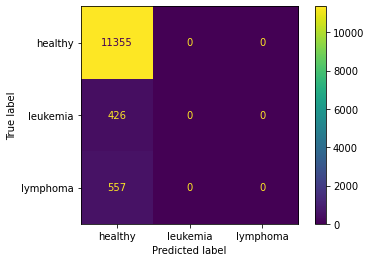

46.40662956237793 seconds or 0.7734438260396321 mins or 0.01289073043399387 hrs


In [101]:
# ML model function
xgb=XGBClassifier()
rf=RandomForestClassifier()
svm_model=svm.SVC()


def model_test_main(model,x_train,y_train,x_test,y_test):
    start_time = time.time()
    print(x_train.columns)
    print(x_test.columns)
    #Hyperparameter dictionaries
    if model == xgb:
        param_grid={'n_estimators'     : np.array([50, 100, 500]),
                    'learning_rate'    : np.array([1e-2, 1e-1, 1]),
                    'max_depth'        : np.array([5, 8, 10])}
        #Encoding labels for xgb compatability
        encoder = LabelEncoder()
        print(y_train)
        y_train = encoder.fit_transform(y_train)
        print(y_train)
    elif model == rf:
        param_grid={'n_estimators'   : np.array([30, 40, 50, 60]),
                    'min_samples_leaf'   : np.array([1, 2, 5]),
                    'max_features' : np.array(['auto','log2']),
                    'criterion' :['gini', 'entropy'],
                    'max_depth':range(2,4,6),
                    'min_samples_split': np.array([2, 5, 10])}
    elif model == svm_model:
        param_grid={'C':[2^(0), 2^(1), 2^(2)],
                    'kernel':['poly','rbf']}
    inner=KFold(n_splits=5,shuffle=True,random_state=0)
    #Inner CV for hyperparameter tuning
    search_results=GridSearchCV(model,param_grid,cv=inner,n_jobs=-1, scoring='f1').fit(x_train,y_train)
    #Selecting optimal hyperparameters
    optimal_params=search_results.best_params_
    print(optimal_params)
    #Re-instantiating models with optimal hyperparameters
    if model==xgb:
        model=XGBClassifier(**optimal_params)
    elif model == rf:
        model =RandomForestClassifier(**optimal_params)    
    elif model==svm_model:
        model=svm.SVC(**optimal_params)
    #Fitting model with optimised parameters to training data
    model.fit(x_train,y_train)

    #Predicting using fitted model on test set
    y_pred = model.predict(x_test)
    print(f'y_pred encoded: {y_pred}')
    #De-encoding labels for xgb
    if isinstance(model,XGBClassifier):
        y_pred = encoder.inverse_transform(y_pred)
        print(f'y_pred UN-encoded: {y_pred}')
    #Results Visualisation
    print('Test Set Results:')
    print(classification_report(y_test,y_pred))
    if 'cancer' in y_pred:
        print(f"AUC: {roc_auc_score(y_test, model.predict_proba(x_test)[:,1])}")
    else:
        print(f"AUC: {roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr')}")
    cmatrix=ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show(cmatrix)
    time_taken=(time.time() - start_time)
    print(f'{time_taken} seconds or {time_taken/60} mins or {time_taken/(60*60)} hrs')
    return(model, y_pred)

model=model_test_main(rf, X_train_subset, y_train, X_test_subset, y_test)

In [102]:
# feature importance using tree impurity
features = X_test_subset.columns
print(model[0])
importances = model[0].feature_importances_
print(importances)
indices = np.argsort(importances)
print(indices)

RandomForestClassifier(max_depth=2, n_estimators=30)
[0.06952436 0.         0.06583269 0.02877419 0.05079558 0.00177542
 0.08446914 0.01319391 0.         0.00441682 0.0055015  0.04827912
 0.41900529 0.0027726  0.         0.00801773 0.19764167]
[ 8  1 14  5 13  9 10 15  7  3 11  4  2  0  6 16 12]


['healthy' 'leukemia' 'lymphoma']


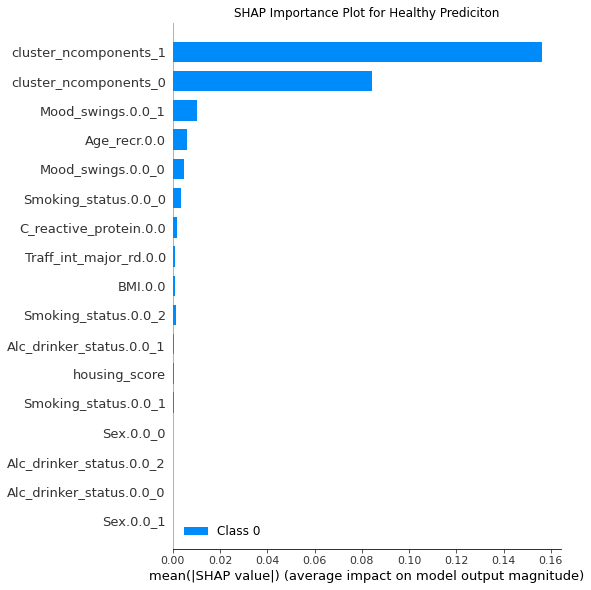

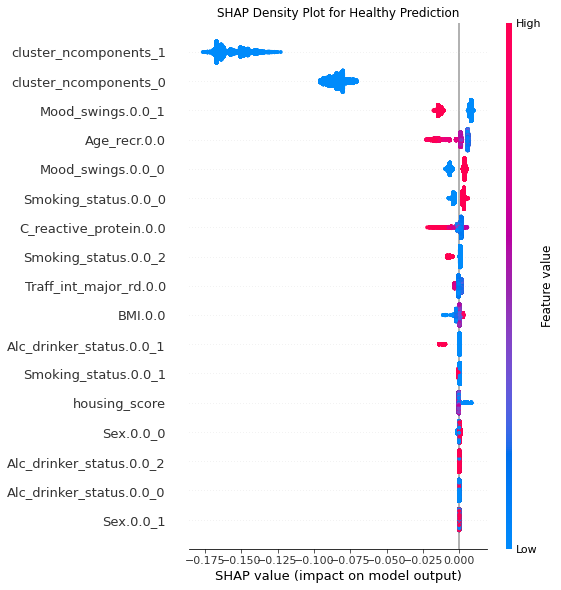

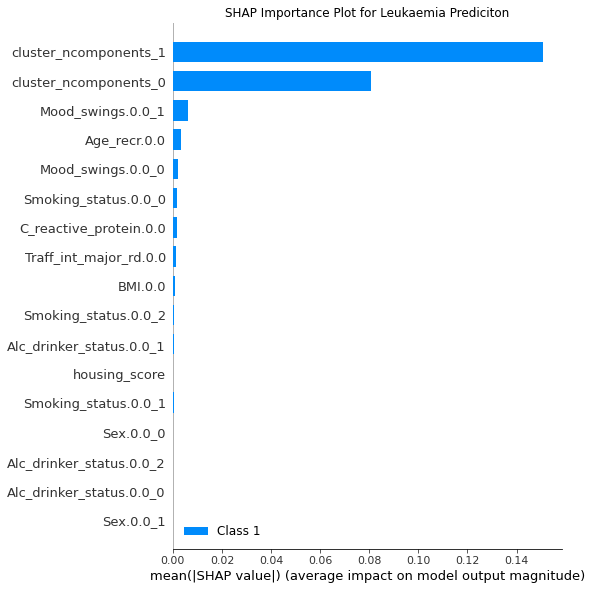

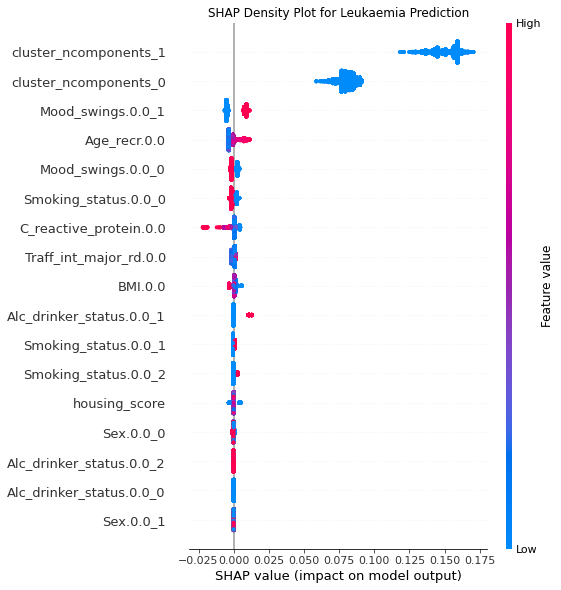

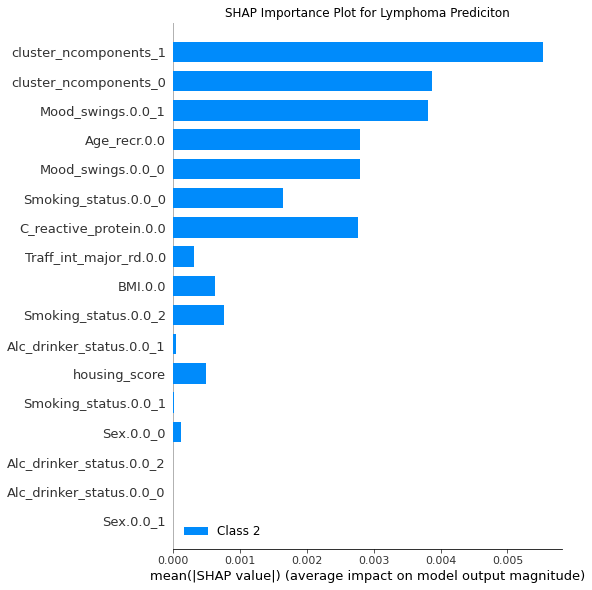

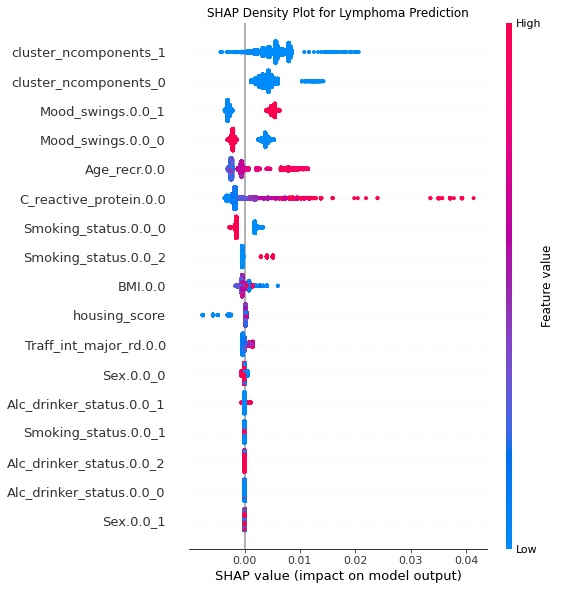

In [103]:
#Select SHAP kernel based on ML model type
if (isinstance(model[0],RandomForestClassifier))|(isinstance(model[0],XGBClassifier)):
    explainer = shap.TreeExplainer(model[0])
elif isinstance(model[0],svm.SVC):
    explainer = shap.KernelExplainer(model[0])

#Generate shap values
shap_values = explainer.shap_values(X_test_subset)
print(model[0].classes_)

#SHAP plots for each class
plt.title('SHAP Importance Plot for Healthy Prediciton')
shap.summary_plot(shap_values, features = X_test_subset, class_inds = [0])
plt.show()

plt.title('SHAP Density Plot for Healthy Prediction')
shap.summary_plot(shap_values[0], features = X_test_subset)
plt.show()

plt.title('SHAP Importance Plot for Leukaemia Prediciton')
shap.summary_plot(shap_values, features = X_test_subset, class_inds = [1])
plt.show()

plt.title('SHAP Density Plot for Leukaemia Prediction')
shap.summary_plot(shap_values[1], features = X_test_subset)
plt.show()

plt.title('SHAP Importance Plot for Lymphoma Prediciton')
shap.summary_plot(shap_values, features = X_test_subset, class_inds = [2])
plt.show()

plt.title('SHAP Density Plot for Lymphoma Prediction')
shap.summary_plot(shap_values[2], features = X_test_subset)
plt.show()


In [85]:
'''
plt.title('SHAP Force Plot for Healthy Prediction')
shap.force_plot(base_value=explainer.expected_value[0], shap_values=shap_values[0])
plt.show()
'''


array([[-1.26119132, -1.08443325, -0.30279575, ..., -0.24352883,
         4.29097692, -1.28364906],
       [-0.2050863 , -1.08443325, -0.23245659, ...,  0.17328222,
        -0.74402838, -1.13668433],
       [ 1.30363517, -1.08443325, -0.30540091, ..., -0.52140286,
        -0.47549476, -0.55521517],
       ...,
       [-2.1664242 ,  0.92214067, -0.01883393, ..., -0.52140286,
        -0.47549476,  1.17002299],
       [ 0.24753014,  0.92214067,  4.46203158, ...,  0.8679673 ,
         1.53850736, -0.23572662],
       [ 0.39840229,  0.92214067,  0.04629493, ..., -0.24352883,
         1.13570693, -0.32518342]])